In [1]:
import os
import time
import math
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


from torch.nn.parameter import Parameter
from copy import deepcopy
from IPython.display import display
from collections import defaultdict
from torchvision import datasets
from torch.distributions import Categorical, Bernoulli 
from torch.utils.data import DataLoader
from IPython.display import clear_output

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
TODO: 

1. solving the problem of NaN
2. still using bmm?
'''

'\nTODO: \n\n1. solving the problem of NaN\n2. still using bmm?\n'

In [2]:
class args(object):
    
    ### Fetching ###
    
    # Inplace can't be used with bmm and element-wise mul simultaneously.
    CNN_Inplace = False # if false, use early output to avoid inf and NaN
    early_output = True 
    training_single_dag = True
    agent = 'ActorCritic'
    fetching_dim = 64
    num_weights = 5 * 3
    num_input_cells = 3
    num_iner_memories = 2
    num_cells = num_input_cells + num_iner_memories 
    num_time_steps = 100 # how many time_step
    num_bns = 3
    num_attns = 2
    num_dropouts = 5
    
    
    num_act_fns = 4
    if CNN_Inplace:
        
        num_putways = 2 # 4 [plus, elememntwise, inplace] 
    else:
        num_putways = 3
        
    num_fetching_steps = 7 # [retr, opt, bn, act, retur, put, output_signal]
    
    ### ActorCritic ###
    emb_dim = 32
    RNN = "LSTM"# Customized, LSTM
    RNN_dim = 128
    RNN_dropout = 0 # 0 
    
    ### Data ###
    
    # img_name = 'mnist'
    
    img_name = 'cifar10'
    
    if img_name == 'cifar10':
        
        img_channel = 1
        img_size = 28
        y_dim = 10
        img_path = '../Data/mnist'
        load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        training_dataset = datasets.MNIST(img_path,train = True, transform = load_norm, download=False)
        test_dataset = datasets.MNIST(img_path,train = False, transform = load_norm, download=False)
        
    else:
        
        img_channel = 3
        img_size = 32
        y_dim = 10
        img_path = '../Data/cifar10'
        load_norm = T.Compose([T.Resize((img_size, img_size)),T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        training_dataset = datasets.CIFAR10(img_path,train = True, transform=load_norm, download=True)
        test_dataset = datasets.CIFAR10(img_path,train = False, transform=load_norm, download=True)

    ### Training ###
    
    eps = 1e-8
    discount = 0.9
    decay = 0.95
    epoch = 150
    batch_size = 5 # 64
    shared_lr = 0.0002
    controller_lr = 0.0002
    
    shared_maxsteps = 5 # 400
    controller_maxsteps = 5 # 2000
    
    controller_sch = False
    controller_sch_steps = 2000
    controller_sch_gamma = 0.75

    shared_sch = False
    shared_sch_steps = 2000
    shared_sch_gamma = 0.75
    
    shared_grad_norm = 0.25
    controller_grad_norm = 0.25
    
    controller_L2 = 0
    shared_L2 = 1e-7

    reward_c = 80
    
    baseline_decay = 0.95
    val_test_steps = 5
    
    critic_coef = 0.5
    entropy_coef = 0.5
    
    model_name = 'FetchingNAS' 
    model_path ='./'+ model_name +'/Model/'
    
    
    
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
to_img= T.Compose([T.ToPILImage()])
to_tensor = T.Compose([T.ToTensor()])
load_norm = T.Compose([T.Resize((args.img_size,args.img_size)),
                       T.ToTensor(),T.Normalize((0.5, 0.5, 0.5),
                                                (0.5, 0.5, 0.5))])

In [3]:
class NeuralAccumulatorCell(nn.Module):
    
    # Feed forward but Weight decomposition
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim

        self.W_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.M_hat = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.tanh(self.W_hat) * torch.sigmoid(self.M_hat))
        self.register_parameter('bias', None)

        init.kaiming_uniform_(self.W_hat, a=math.sqrt(5))
        init.kaiming_uniform_(self.M_hat, a=math.sqrt(5))
        
        #init.normal_(self.W_hat)
        #init.normal_(self.M_hat)
        
    def forward(self, input):
        return F.linear(input, self.W, self.bias)


class NAC(nn.Module):
    
    def __init__(self, dims):
        '''
        dims = [input_dim + hidden_dims + output_dims]
        '''
        super().__init__()
        self.num_layers = len(dims) - 1
        
        layers = nn.ModuleList()
        layers.extend([NeuralAccumulatorCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NeuralArithmeticLogicUnitCell(nn.Module):

    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.eps = 1e-10

        self.G = Parameter(torch.Tensor(out_dim, in_dim))
        self.W = Parameter(torch.Tensor(out_dim, in_dim))
        self.register_parameter('bias', None)
        self.nac = NeuralAccumulatorCell(in_dim, out_dim)

        init.kaiming_uniform_(self.G, a = math.sqrt(5))
        init.kaiming_uniform_(self.W, a = math.sqrt(5))

    def forward(self, input):
        
        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))
        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)
        m = torch.exp(self.nac(log_input))
        # m = torch.exp(F.linear(log_input, self.W, self.bias))
        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y


class NALU(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.num_layers = len(dims) - 1
        layers = nn.ModuleList()
        layers.extend([NeuralArithmeticLogicUnitCell(dims[i],dims[i+1]) for i in range(self.num_layers)])
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(x)
        return out

class NALU_LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Sequential(
            nn.Linear(input_size, 4 * hidden_size, bias=bias),
            nn.LayerNorm(4 * hidden_size),
        )
        self.h2h = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size, bias=bias),
            nn.LayerNorm(4 * hidden_size),
        )
        self.nalu_h = NALU([hidden_size, hidden_size])
        self.nalu_c = NALU([hidden_size, hidden_size])
        
#         self.apply(self.weight_init)

    def weight_init(self,m):

        std = 1.0 / math.sqrt(self.hidden_size)
        for name, w in m.named_parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden = None):
        
        if hidden is None:
            hidden = x.new_zeros(x.size(0), self.hidden_size, requires_grad=False)
            hidden = (hidden, hidden)
            
        h, c = hidden
        
        preact = self.i2h(x) + self.h2h(h)
        
        # First: apply nalu to replace activation func
        
        # self.nalu(preact)
        
        gates = preact[:, :3 * self.hidden_size].sigmoid()
        g_t = preact[:, 3 * self.hidden_size:].tanh()
        i_t = gates[:, :self.hidden_size] 
        f_t = gates[:, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, -self.hidden_size:]
        
        # Second: Apply it in the output and hidden layer

        c_t = (c*f_t) + (i_t*g_t)

        h_t = o_t * c_t.tanh()
        
        # return x, (h_t, c_t) # LSTM
        
        # return x + self.out(h_t), (h_t + h, c_t + c) # Residule LSTM

        return  self.nalu_h(h_t + h), self.nalu_c(c_t + c) # Residule NALU

class NALU_LSTM(nn.Module):
    
    def __init__(self,input_size, hidden_sizes, bidirectional = False):
        
        super().__init__()
        self.bidirectional = bidirectional
        
        if self.bidirectional:
            self.num_dir = 2
        else:
            self.num_dir = 1
            
        self.input_size = input_size
        self.L = len(hidden_sizes)
        self.layers = nn.ModuleList()
        self.layers.extend([NALU_LSTMCell(input_size,i) for i in hidden_sizes])
        self.c0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        self.h0 = nn.ParameterList([nn.Parameter(torch.randn(self.num_dir, 1,i)) for i in hidden_sizes])
        
        
    def forward(self, input):
        
        '''
        input_shape = B, S, input_size
        output_shape = B, num_dir, L, S, input_size
        hidden, cells = S * (B, hidden_dim)
        '''
        
        B,S = input.shape[:-1]
        
        outputs = torch.zeros(B, self.num_dir, self.L+1, S, self.input_size)
        outputs[:,:,0,:,:] = input.unsqueeze(1).expand_as(outputs[:,:,0,:,:])
        hiddens = []
        cells = []
    
        for i, layer in enumerate(self.layers):
            f_h, f_c = self.h0[i][0].repeat(B,1), self.c0[i][0].repeat(B,1)
            if self.bidirectional:
                i_h, i_c = self.h0[i][1].repeat(B,1), self.c0[i][1].repeat(B,1)
            for j in range(S):
                f_out, (f_h,f_c) = layer(outputs[:,0,i,j,:].clone(), (f_h,f_c))
                outputs[:,0,i+1,j,:] = f_out

            if self.bidirectional:
                for j in reversed(range(S)):
                    i_out, (i_h,i_c) = layer(outputs[:,1,i,j,:].clone(), (i_h,i_c))
                    outputs[:,1,i+1,j,:] = i_out
                hiddens.append((torch.stack([f_h,i_h])))
                cells.append(torch.stack([f_c,i_c]))
            else:
                hiddens.append(f_h)
                cells.append(f_c)
                
        #outputs = outputs[:,:,-1:,:,:]
        return outputs[:,:,1:,:,:].contiguous(), (hiddens, cells)

In [4]:
def dags_translate(dags_):
    
    dags = deepcopy(dags_)
    
        
    for dag in dags:

        if dag['Act_fn'] == 0:
            dag['Act_fn'] = 'Sigmoid'
        elif dag['Act_fn'] == 1:
            dag['Act_fn'] = 'ReLU'
        elif dag['Act_fn'] == 2:
            dag['Act_fn'] = 'LeakyReLU'
        elif dag['Act_fn'] == 3:
            dag['Act_fn'] = 'Tanh'

        if args.CNN_Inplace:

            if dag['Put'] == 0:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 1:
                dag['Put'] = 'Inplace'

        else:

            if dag['Put'] == 0:
                dag['Put'] = 'Plus'
            elif dag['Put'] == 1:
                dag['Put'] = 'Emlement_Wise*'
            elif dag['Put'] == 2:
                dag['Put'] = 'Bmm'
    
        dag['Output'] = bool(dag['Output'])
                
        
    return dags

class Flatten(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
    def forward(self,x):
        return (x.view(x.size(0),-1))


In [5]:
class CNNCell_Inplace(nn.Module):
    
    def __init__(self, dim = 32, num_conv = 5, num_bn = 5, num_attns = 2, num_cells = 5):
        super().__init__()
        
        '''
        The dim has to be more than 8
        '''
        
        self.num_cells = num_cells
        self.convs = nn.ModuleList()
        self.convs.extend([nn.Conv2d(dim, dim, 3, 1, 1) for _ in range(num_conv)])
        self.convs.extend([nn.Conv2d(dim, dim, 5, 1, 2) for _ in range(num_conv)])
        self.convs.extend([nn.Conv2d(dim, dim, 1, 1, 0) for _ in range(num_conv)])
        
        self.act_funcs = nn.ModuleList()
        self.act_funcs.extend([nn.Sigmoid(),
                               nn.ReLU(inplace=True),
                               nn.LeakyReLU(0.2,inplace=True),
                               nn.Tanh(),
                              ])
        if num_bn > 0:
            self.BNs = nn.ModuleList()
            self.BNs.append(nn.BatchNorm2d(dim, affine= False))
            self.BNs.extend([nn.BatchNorm2d(dim) for _ in range(num_bn-1)])
        
        self.iner_memories = nn.ParameterList()
        self.iner_memories.extend([nn.Parameter(torch.randn(1,args.fetching_dim, args.img_size, args.img_size)) for _ in range(args.num_iner_memories)])
        
    def forward(self, x, dags):
        
        B,C,W,H = x.size()
        
        cells = [x] * (args.num_input_cells) + [m.repeat(B,1,1,1) for m in [*self.iner_memories]] 
        
        N = W * H
        
        for i, dag in enumerate(dags):
            opting_cell = cells[dag['Retrieve_cell']].clone()
            if not dag['Operation'] is None:
                opting_cell = self.convs[dag['Operation']](opting_cell)
                    
            if not dag['BatchNorm'] is None: 
                opting_cell = self.BNs[dag['BatchNorm']](opting_cell)
                    
            if not dag['Act_fn'] is None:
                opting_cell = self.act_funcs[dag['Act_fn']](opting_cell)
                    
            if dag['Put'] == 0:
                
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
                
            elif dag['Put'] == 1:
                
                cells[dag['Return_cell']] = opting_cell
            
            else: 
                raise NotImplementedError
                
            if args.early_output and dag['Output']:
                return cells[dag['Return_cell']]
            
        return cells[dag['Return_cell']]
    

In [6]:
class CNNCell(nn.Module):
    
    def __init__(self, dim = 32, num_conv = 5, num_bn = 5, num_attns = 2, num_cells = 5):
        super().__init__()
        
        '''
        The dim has to be more than 8
        '''
        
        self.num_cells = num_cells
        self.convs = nn.ModuleList()
        self.convs.extend([nn.Conv2d(dim, dim, 3, 1, 1) for _ in range(num_conv)])
        self.convs.extend([nn.Conv2d(dim, dim, 5, 1, 2) for _ in range(num_conv)])
        self.convs.extend([nn.Conv2d(dim, dim, 1, 1, 0) for _ in range(num_conv)])
        
        self.act_funcs = nn.ModuleList()
        self.act_funcs.extend([nn.Sigmoid(),
                               nn.ReLU(inplace=True),
                               nn.LeakyReLU(0.2,inplace=True),
                               nn.Tanh(),
                              ])
        if num_bn > 0:
            self.BNs = nn.ModuleList()
            self.BNs.append(nn.BatchNorm2d(dim, affine= False))
            self.BNs.extend([nn.BatchNorm2d(dim) for _ in range(num_bn-1)])
        
        
        self.iner_memories = nn.ParameterList()
        self.iner_memories.extend([nn.Parameter(torch.randn(1,args.fetching_dim, args.img_size, args.img_size)) for _ in range(args.num_iner_memories)])
        
    def forward(self, x, dags):
        
        B,C,W,H = x.size()
        
        cells = [x] * (args.num_input_cells) + [m.repeat(B,1,1,1) for m in [*self.iner_memories]] 
        
        N = W * H
        
        for i, dag in enumerate(dags):
            opting_cell = cells[dag['Retrieve_cell']].clone()
            if not dag['Operation'] is None:
                opting_cell = self.convs[dag['Operation']](opting_cell)
            if not dag['BatchNorm'] is None: 
                opting_cell = self.BNs[dag['BatchNorm']](opting_cell)
            if not dag['Act_fn'] is None:
                opting_cell = self.act_funcs[dag['Act_fn']](opting_cell)
                

            if dag['Put'] == 0:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] + opting_cell
            elif dag['Put'] == 1:
                cells[dag['Return_cell']] = cells[dag['Return_cell']] * opting_cell
            elif dag['Put'] == 2:
                cells[dag['Return_cell']] = torch.bmm(opting_cell.view(-1,W,H),cells[dag['Return_cell']].view(-1,W,H).permute(0,2,1)).view(B,C,W,H)
            else: 
                raise NotImplementedError
                
            # controlling nan output
            print('The NaN portion: ', (torch.isnan(cells[dag['Return_cell']]).sum()/cells[dag['Return_cell']].nelement()))
            
            cells[dag['Return_cell']][torch.isnan(cells[dag['Return_cell']])] = 0
            
            if args.early_output and dag['Output']:
                return cells[dag['Return_cell']]
            
        return cells[dag['Return_cell']]
    

In [7]:
class CNNContainer(nn.Module):
    
    def __init__(self,):
        
        '''
        For MNIST
        '''
        
        super().__init__()
        
        if args.CNN_Inplace:
            self.cnn_cell = CNNCell_Inplace(args.fetching_dim, args.num_weights, args.num_bns, args.num_attns, args.num_cells)
        else: 
            self.cnn_cell = CNNCell(args.fetching_dim, args.num_weights, args.num_bns, args.num_attns, args.num_cells)
        
        self.cnn_st = nn.Sequential(
            nn.Conv2d(args.img_channel, args.fetching_dim, 1, 1, 0),
        )
        

        self.cnn_end = nn.Sequential(
            nn.Conv2d(args.fetching_dim, 1, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace=True),
            Flatten(),
            nn.Linear(args.img_size*args.img_size, 10),
#             nn.LogSoftmax(dim=-1),
#             nn.Softmax(dim = -1),
        )
        
#         self.Loss = nn.NLLLoss()
        self.Loss = nn.CrossEntropyLoss()

    def forward(self, x, dags):
        
        input_ = self.cnn_st(x)
        
        output = self.cnn_cell(input_, dags)
        
        output = self.cnn_end(output)
        
        return output
        
    def get_loss(self, loader, dags):
        
        imgs, targets = iter(loader).next()
        
        imgs = imgs.to(device)
        
        targets = targets.to(device)
            
        out = self.forward(imgs, dags[0])
            
        loss = self.Loss(out, targets)
        
        return loss
    
    def num_all_params(self,):
        
        return sum([param.nelement() for param in self.parameters()])
            
        

In [8]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        '''
        ActorCrtic For CNN
        '''
        self.retr_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.opt_emb = nn.Embedding(args.num_weights + 1, args.emb_dim)  
        self.bn_emb = nn.Embedding(args.num_bns +1, args.emb_dim)
        self.act_emb = nn.Embedding(args.num_act_fns + 1, args.emb_dim)
        self.put_emb = nn.Embedding(args.num_putways, args.emb_dim)
        self.return_emb = nn.Embedding(args.num_cells, args.emb_dim)
        self.out_emb = nn.Embedding(2, args.emb_dim)
        
        if args.RNN == "LSTM":
            self.rnn = nn.LSTMCell(args.emb_dim * args.num_fetching_steps, args.RNN_dim)
       
        elif args.RNN == "Customized":
            self.rnn = NALU_LSTMCell(args.emb_dim * args.num_fetching_steps, args.RNN_dim)
            
        self.drop = nn.Dropout(args.RNN_dropout)
        
        self.retr_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_cells),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        self.opt_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_weights + 1),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        self.bn_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_bns + 1),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        self.act_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_act_fns + 1),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        # Question: Can the Normal algorithm perform Self-Attn
        
        self.put_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_putways),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        self.return_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,args.num_cells),
            nn.Softmax(-1),
#             nn.LogSoftmax(dim=-1),
        )
        
        self.output_net = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.LayerNorm(args.RNN_dim//4),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Linear(args.RNN_dim//4 ,1),
            nn.Sigmoid(),
        )
        
        self.critic = nn.Sequential(
            nn.Linear(args.RNN_dim, args.RNN_dim//4),
            nn.ReLU(),
            nn.Linear(args.RNN_dim //4 , 1),
        )
        
#         self.apply(self.weight_init)
        
    def forward(self, x, hidden = None):
        
        '''
        # (Retrieve, opt(0~args.num_weight), BN(0~args.num_weight), Act_fn(0~args.num_act_fns), 
        Attn(0~args.num_Attn, Return, Put(0~args.num_putways-1))
        
        # Question : should I do the dropout in the controller.
        
        in short: [retr, opt, bn, act, attn, retur, put, output_signal]
        '''
        
        args.x = x
        
        retr_e = self.retr_emb(x[:,0])
        opt_e = self.opt_emb(x[:,1])
        bn_e = self.bn_emb(x[:,2])
        act_e = self.act_emb(x[:,3])
        return_e = self.return_emb(x[:,4])
        put_e = self.put_emb(x[:,5])
        output_e = self.out_emb(x[:,6])
        
        rnn_input = torch.cat([retr_e, opt_e, bn_e, act_e, return_e, put_e, output_e],1)
        
        
        args.rnn_input = rnn_input
        
        args.hidden = hidden
        
        h, c = self.rnn(rnn_input, hidden)
        
        args.h = h
        
        h_droped = self.drop(h)
        
        retr_dist = Categorical(self.retr_net(h_droped))
        opt_dist = Categorical(self.opt_net(h_droped))
        bn_dist = Categorical(self.bn_net(h_droped))
        act_dist = Categorical(self.act_net(h_droped))
        return_dist = Categorical(self.return_net(h_droped))
        put_dist = Categorical(self.put_net(h_droped))
        output_dist = Bernoulli(self.output_net(h_droped))

        
        dists = (retr_dist, opt_dist, bn_dist, act_dist, return_dist, put_dist, output_dist)
        
        value = self.critic(h)
        
        return dists , (h,c), value
            
    def sample(self, x, hidden = None, with_detials = False):
        
        dists, hidden, value = self.forward(x, hidden)
        
        retr_dist, opt_dist, bn_dist, act_dist, return_dist, put_dist, output_dist = dists 
        retr = retr_dist.sample()
        opt = opt_dist.sample()
        bn = bn_dist.sample()
        act = act_dist.sample()
        retur = return_dist.sample()
        put = put_dist.sample()
        output_s = output_dist.sample().squeeze(-1)

        samples = torch.stack([retr, opt, bn, act, retur, put, output_s.long()],1)
        
        if with_detials:
            
            entropy = torch.stack([retr_dist.entropy(), opt_dist.entropy(), bn_dist.entropy(),
                        act_dist.entropy(), return_dist.entropy(),
                        put_dist.entropy(), output_dist.entropy().squeeze(-1), ],-1)

            retr_logprob = retr_dist.log_prob(retr)
            opt_logprob = opt_dist.log_prob(opt)
            bn_logprob = bn_dist.log_prob(bn)
            act_logprob = act_dist.log_prob(act)
            return_logprob = return_dist.log_prob(retur)
            put_log_prob = put_dist.log_prob(put)
            output_log_prob = output_dist.log_prob(output_s).squeeze(-1)
            log_probs = torch.stack([retr_logprob, opt_logprob, bn_logprob, act_logprob,
                                     return_logprob, put_log_prob, output_log_prob,],1)
            
            return samples, hidden, entropy, log_probs, value
        
        return samples, hidden
    
    def generate_dags(self, samples):
        
        # [retr, opt, bn, act, attn, retur, put]
        
        dags = []
        for sample in samples:
            
            dag_dict = {}
            
            dag_dict['Retrieve_cell'] = sample[0].item()
            
            if sample[1] == 0:
                
                dag_dict['Operation'] = None
            else:
                
                dag_dict['Operation'] = sample[1].item() - 1
                
            if sample[2] == 0:
                
                dag_dict['BatchNorm'] = None
            else:
                dag_dict['BatchNorm'] = sample[2].item() - 1
                
            if sample[3] == 0:
                dag_dict['Act_fn'] = None
            else:
                dag_dict['Act_fn'] = sample[3].item() - 1
                
            dag_dict['Return_cell'] = sample[4].item()

            dag_dict['Put'] = sample[5].item()
            
            dag_dict['Output'] = sample[6].item()
            
            dags.append(dag_dict)
            
        return dags
    
    def straight_dags(self, x = None, hidden = None, num_steps = 5 , batch_size = 1, with_details = False):
        
        if x is None:
            
            x = torch.ones(batch_size,args.num_fetching_steps).to(device).long() # test the performance for ones and zeros
        
        sample_list = []
        entropies = []
        log_probs = []
        values = []
        
        for _ in range(args.num_time_steps): 
            
            if with_details:
                
                x, hidden, entropy, log_prob, value = self.sample(x, hidden, with_detials = True)
                entropies.append(entropy)
                log_probs.append(log_prob)
                values.append(value)
                
            else:
                x, hidden = self.sample(x, hidden)    
                
            sample_list.append(x)
            
        samples = torch.stack(sample_list,1)
        
        dags_dict_list = []
        
        for dag in samples:
#             batch_order 
            dags_dict_list.append(self.generate_dags(dag))
        
            
        if with_details: 
            return dags_dict_list, torch.stack(entropies,1).sum(-1).squeeze().unsqueeze(-1), torch.stack(log_probs,1).squeeze(),torch.stack(values,1).squeeze().unsqueeze(-1)
    
        return dags_dict_list
        

In [9]:
def compute_gae(rewards, values, gamma=0.99, tau=0.95):
    '''
    Also use GAE in PPO.
    '''
    rewards = [0] * (values.size(0)-1) + [rewards]
    values = torch.cat([values,torch.tensor([[0.]]).to(device)],0)
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1]  - values[step] # Remove the gamma in here?
        gae = delta + gamma * tau * gae # -value[step] will be used in the GAE step
        returns.insert(0, gae + values[step]) # put the new one at the first, cuz we are calculating the A_GAE inversely.
    return torch.stack(returns,0) # cuz we need the gradient of value, so we have to + value[step]

In [10]:
class FetchingNAS(nn.Module):
    
    def __init__(self,):
        super().__init__()
        
        self.shared = CNNContainer()
        self.controller = ActorCritic()
        
        self.training_loader = DataLoader(args.training_dataset,
                                    batch_size= args.batch_size,
                                    shuffle=True, drop_last = True)
        self.valid_loader = DataLoader(args.test_dataset,
                                    batch_size= args.batch_size,
                                    shuffle=True, drop_last = True)
        
        self.shared_optim = optim.Adam(self.shared.parameters(), lr = args.shared_lr, weight_decay = args.shared_L2)
        self.controller_optim = optim.Adam(self.controller.parameters(), lr = args.controller_lr, weight_decay = args.controller_L2)
        
        if args.controller_sch:
            self.controller_scheduler = optim.lr_scheduler.StepLR(self.controller_optim, args.controller_sch_steps, gamma = args.controller_sch_gamma)
            
        if args.shared_sch:
            self.shared_scheduler = optim.lr_scheduler.StepLR(self.shared_optim, args.shared_sch_steps, gamma = args.shared_sch_gamma)
        
        
        self.CE = nn.CrossEntropyLoss()
#         self.CE = nn.NLLLoss()
        self.max_R = None
        self.best_dag = None
        self.controller_hist = defaultdict(list)
        
        self.apply(self.weight_init)
        
    def train_shared(self,):
        
        self.shared.train()
        
        self.controller.eval()
        
        step = 0
        
        self.shared_losses = []
        
        if args.training_single_dag:
        
            dags = self.controller.straight_dags(num_steps = args.num_time_steps)
        
        while step < args.shared_maxsteps:
            
            if args.shared_sch:
                
                self.shared_scheduler.step()
            
            self.shared_optim.zero_grad()
            
            if not args.training_single_dag:
                
                dags = self.controller.straight_dags(num_steps = args.num_time_steps)
            
            loss = self.shared.get_loss(self.training_loader, dags)
            
            loss.backward()
            
            self.shared_losses.append(loss.item())
            
            if not args.shared_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.shared.parameters(), args.shared_grad_norm)
            
            self.shared_optim.step()
            
            step += 1 
    
    def get_reward(self, dags, entropies,):
        
        loss = 0
        
        i = 0
        
        for i in range(args.val_test_steps):
            
            v_loss = self.shared.get_loss(self.valid_loader, dags)
            
            if torch.isnan(v_loss):
                
                loss += torch.tensor(float('inf'))
                
            else: 
                
                loss += v_loss
                
        loss /= args.val_test_steps
        
        loss_ppl = loss.exp()
        
        R = (args.reward_c / ((loss_ppl**2) + args.eps)) # * torch.ones_like(entropies)
        
        return R
        
        # If we sample a dag a time, then change the structure of sampling dag    
            
    def train_controller(self,):
        
        self.controller.train()
        
        step = 0
        
        self.en_losses = []
    
        self.controller_losses = []
        
        self.actor_losses = []
        
        self.critic_losses = []
        
        self.real_entropies = []
        
        baseline = None
        
        while step < args.controller_maxsteps:
            
            if args.controller_sch:
                self.controller_scheduler.step()
            
            self.controller_optim.zero_grad()
            
            dags, entropy, log_prob, value = self.controller.straight_dags(num_steps = args.num_time_steps ,with_details = True)
        
            with torch.no_grad():
                
                R = self.get_reward(dags, entropy)
                
            if self.max_R is None:
                self.max_R = R.max()
                self.best_dag = dags[0]
            else:
                if R.max() > self.max_R:
                    self.max_R = R.max()
                    self.best_dag = dags[0]
             
            self.controller_hist['Rewards'].append(R.item())
            
            if args.agent == 'ActorCritic':
            
                returns = compute_gae(R, value)

                adv = returns.detach() - value 

                actor_loss = ( - log_prob * adv).mean()

                critic_loss = args.critic_coef * adv.pow(2).mean() 

                en_loss = args.entropy_coef * entropy.mean()

                loss = actor_loss + critic_loss - en_loss
                
            elif args.agent == 'PolicyGradient':
                
                if baseline is None:
                    
                    baseline = R
                    
                else:
                
                    baseline = args.decay * baseline + (1 - args.decay) * R

                adv = R - baseline
                
                actor_loss = ( - log_prob * adv ).mean()
                
                critic_loss = torch.tensor(0)

                en_loss = args.entropy_coef * entropy.mean()

                loss = actor_loss - en_loss
                
            else:
                
                raise NotImplementedError
                
            
            self.actor_losses.append(actor_loss.item())
            self.critic_losses.append(critic_loss.item())
            self.en_losses.append(-en_loss.item())
            self.controller_losses.append(loss.item())
            self.real_entropies.append(entropy.mean().item())
            
            loss.backward()
            
            if not args.controller_grad_norm is None:
                
                nn.utils.clip_grad_norm_(self.controller.parameters(), args.controller_grad_norm)
            
            self.controller_optim.step()
            
            step += 1
        
    
    def train(self, n_epoch, save_freq = 30):
        
        start_t = time.time()

        for self.epoch in range(n_epoch):
            
            self.train_shared()
            
            # Trian the shared model's parameter for shared_maxsteps

            self.train_controller()
            
            self.plot_controller_hist('_Rewards')
            
            end_t = time.time()
            
            display(self.dags_df(dags_translate(self.best_dag),delete = args.early_output))
            
            print('Epoch : [%d] Lasting Time: [%.4f]'% (self.epoch, end_t - start_t))
            
            print('Controller [%.4f] | Actor [%.4f] | Critic [%.4f] | Entropy [%.4f] | R_Entropy [%.4f]' %\
                   (sum(self.controller_losses) / len(self.controller_losses),
                   (sum(self.actor_losses) /len(self.actor_losses)),
                   (sum(self.critic_losses) /len(self.critic_losses)),
                   (sum(self.en_losses) /len(self.en_losses)),
                   (sum(self.real_entropies) /len(self.real_entropies)),
                  ))
            
            print('Shared [%.4f]'%(sum(self.shared_losses)/ len(self.shared_losses)))
            
            if self.epoch % save_freq == 0 and self.epoch != 0:
                self.model_save('Training')
            # Train controller for controler_maxsteps
            
    def plot_controller_hist(self, step):
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        for name in self.controller_hist.keys():
            plt.plot(self.controller_hist[name], label = name)
            plt.xlabel('Number of Steps',fontsize=15)
            plt.ylabel( name, fontsize=15)
            plt.title(name, fontsize=30, fontweight ="bold")
            plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        fig.savefig("Train_Hist"+str(step)+".png")
    
    def num_all_params(self,):
        
        return sum([param.nelement() for param in self.parameters()])
    
    def model_save(self, step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name: self.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
        
    def dags_df(self, dags, delete = False):
        
        if delete:
            
            df = pd.DataFrame(dags)[['Retrieve_cell','Operation','BatchNorm','Act_fn','Return_cell','Put','Output']]
        
            idx_list = df.index[df['Output']].tolist()
        
            if len(idx_list) == 0:
                return df
            
            else:
                idx = idx_list[0]
        
            return df.loc[:idx]
        
        else:
            
            df = pd.DataFrame(dags)[['Retrieve_cell','Operation','BatchNorm','Act_fn','Return_cell','Put']]
            
            return df 

    def weight_init(self,m):
        
#         if type(m) in [nn.Conv2d, nn.ConvTranspose2d]:
#             nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        if type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    print(name, 'initialised')
                    nn.init.orthogonal_(value.data)
#                     nn.init.xavier_normal_(value.data)
                if 'bias'in name:
#                     value.data.normal_()
                    l = len(value.data)
                    value[l // 4:l // 2].data.fill_(1.0)
        elif type(m) in [NALU_LSTMCell]:
            for name, value in m.named_parameters():
                if '0.weight' in name :
                    nn.init.orthogonal_(value.data)
                if '0.bias'in name:
                    l = len(value.data)
                    value[l // 4:l // 2].data.fill_(1.0)
 

In [11]:
Fet = FetchingNAS().to(device)

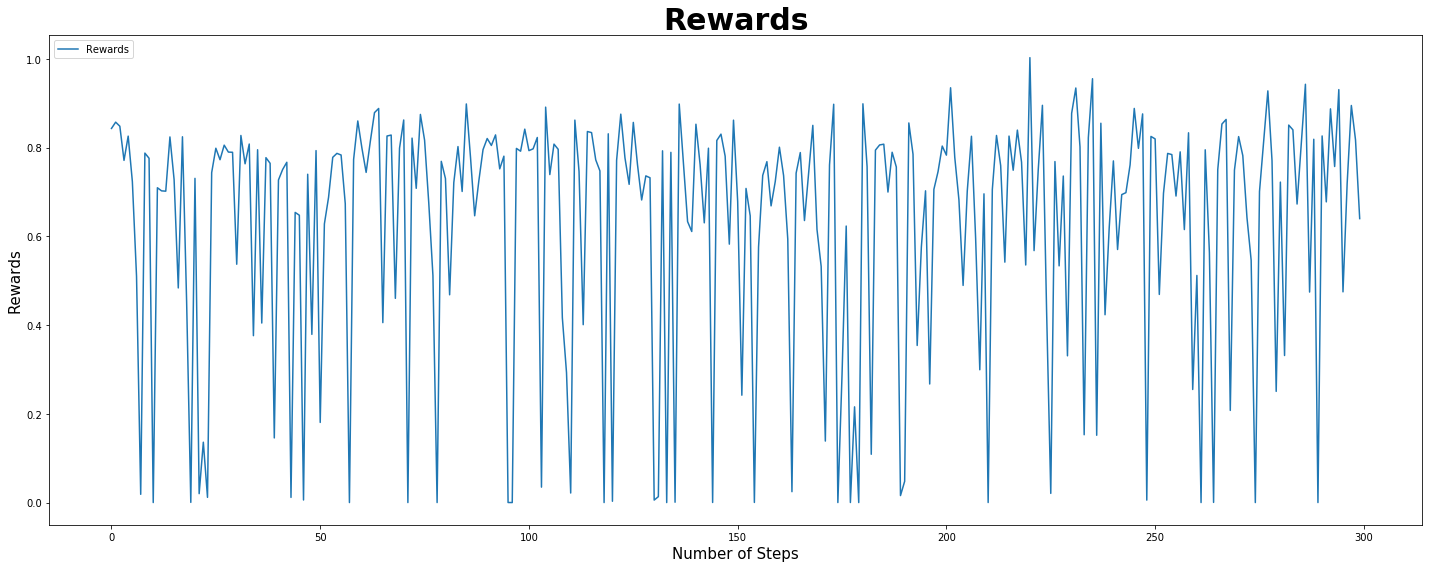

,Retrieve_cell,Operation,BatchNorm,Act_fn,Return_cell,Put,Output
0,1,4.0,1.0,Tanh,0,Plus,True


Epoch : [59] Lasting Time: [195.2714]
Controller [-6.1681] | Actor [-2.3688] | Critic [1.5890] | Entropy [-5.3884] | R_Entropy [10.7768]
Shared [4.4605]
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN portion:  tensor(0)
The NaN

In [ ]:
Fet.train(200) # for testing the SGD and Adam

In [ ]:
args.dag

In [ ]:
torch.max(args.value_before_put)

In [ ]:
torch.bmm(opting_cell.view(-1,W,H),cells[dag['Return_cell']].view(-1,W,H).permute(0,2,1)).view(B,C,W,H)



In [ ]:
torch.isinf(args.o_cells[2]).sum()

In [ ]:
torch.isinf(args.value_before_put).sum()

In [ ]:
args.value_before_put.shape

In [ ]:
# bmm 容易造成 inf

In [ ]:
Epoch : [5] Lasting Time: [554.2417]
Controller [-0.2520] | Actor [-0.2723] | Critic [0.0216] | Entropy [-0.0012] | R_Entropy [12.1758]
Shared [2.3031]

In [ ]:
torch.bmm(args.value_before_put.view(-1))

In [ ]:
args.o_cells[2]

In [ ]:
args.dags

In [ ]:
for i, value in enumerate(args.cells):
    if torch.sum(torch.isnan(value)) > 0:
        print(i)

In [ ]:
# find the rason of causing NaN in the shared

In [ ]:

        for i, dag in enumerate(dags):
            opting_cell = cells[dag['Retrieve_cell']].clone()
            
            if torch.sum(torch.isnan(opting_cell))>0:
                print('Found NaN in the retrieving stage')
                args.cells = cells
                args.dags = dags
                args.dag = dag
                raise StopIteration
            
            if not dag['Operation'] is None:
                opting_cell = self.convs[dag['Operation']](opting_cell)
                if torch.sum(torch.isnan(opting_cell))>0:
                    print('Found NaN in the convs stage')
                    args.cells = cells
                    args.dags = dags
                    args.dag = dag
                    raise StopIteration

In [ ]:
for p in Fet.shared.cnn_cell.convs[8].parameters():
    print(torch.sum(torch.isnan(p)))

In [ ]:
result = Fet.shared.cnn_cell.convs[8](args.cells[1])

In [ ]:
torch.isnan(Fet.shared.cnn_cell.convs[8].bias).sum()

In [ ]:
torch.isnan(Fet.shared.cnn_cell.convs[8].weight).sum() # no NaN in the weight and args.cells[1]

# however, we got problem after the convlution operation

In [ ]:
# check inf as well since the NaN may be caused by the inf

In [ ]:
result_without_bias = F.conv2d(args.cells[1], Fet.shared.cnn_cell.convs[8].weight)

In [ ]:
torch.isnan(result_without_bias).sum()

In [ ]:
torch.isnan(result_without_bias)

In [ ]:
torch.tensor(float('inf')) * -torch.tensor(float('inf')) + torch.tensor(float('inf')) 

In [ ]:
torch.sum(torch.isinf(Fet.shared.cnn_cell.convs[8].weight))

In [ ]:
torch.sum(torch.isinf(args.cells[1]))

In [ ]:
torch.isnan(args.cells[1]).sum()

In [ ]:
Fet.shared.cnn_cell.convs[8].weight.shape

In [ ]:
Fet.shared.cnn_cell.convs[8].bias

In [ ]:
args.cells[1].shape 

In [ ]:
import torch.nn.functional as F

In [ ]:
torch.isinf() # it can detec both positive and negaitive infinite

In [ ]:
torch.tensor((float('inf')))-torch.tensor(float('inf')) # inf - inf will cause NaN it may be the cause of the NaN -> it's reasonable to replace NaN as 0
# Therefor the inf has to be detected

In [ ]:
args.cells[1]

In [ ]:
Fet.shared.cnn_cell.convs[8].weight

In [ ]:
result_with_bias = F.conv2d(args.cells[1], Fet.shared.cnn_cell.convs[8].weight, Fet.shared.cnn_cell.convs[8].bias )

In [ ]:
torch.isnan(result_with_bias).sum()

In [ ]:
# chose inplace or dropout, 

# remove dropout

'''
pros of dropout: regularization but the contollerer model is trained to maximise the reward on validation set .
'''

In [ ]:
# score = 70 + 12 + 35 + 68 + 60 + 70

In [ ]:
# score

In [ ]:
# (350/(412))*312

In [ ]:
Fet.controller.rnn(args.rnn_input, args.hidden)

In [ ]:
args.rnn_input

In [ ]:
args.hidden[1]

In [ ]:
# Solve the problem of causing NaN in the shared model.

In [ ]:
args.rnn_input

In [ ]:
Fet.controller.rnn

In [ ]:
# original LSTM solve the problem of NaN in the controller?

In [ ]:
for name, value in Fet.controller.named_parameters():
    if torch.sum(torch.isnan(value))>0:
        print(name)

In [ ]:
'''
255/15
'''

In [ ]:
torch.sum(torch.isnan(args.rnn_input))

In [ ]:
Fet.plot_controller_hist('test')

In [ ]:
args.dag

In [ ]:
args.dags

In [ ]:
args.cells[0]

In [ ]:
# Solurion 1 : detect the nan number in the validating step
# loss explosion problem

In [ ]:
k = torch.tensor(3e-8)

In [ ]:
# (1-nan) and do the elemente-wise multiplication? masking the nan value.

In [ ]:
# what's the reason of causing nan?

In [ ]:
for name, value in Fet.shared.cnn_cell.named_parameters(): 
#     if torch.sum(torch.isnan(value))>0:
    print('Name: ', name)
    print('Value: ', value)

In [ ]:
# BN logsoftmax

# Fet.controller_optim.param_groups[0]['lr'] = 0.0002
# Fet.shared_optim.param_groups[0]['lr'] = 0.0002

In [ ]:
'''
For training the best_dag directly
'''

training_loader = DataLoader(args.training_dataset,
                             batch_size= args.batch_size,
                             shuffle=True)

valid_loader = DataLoader(args.test_dataset,
                          batch_size = args.batch_size,
                          shuffle=True)
C = CNNContainer()
opt = optim.Adam(C.parameters(), lr = 0.0002, weight_decay= args.shared_L2 )

steps = 5000
valid_loss = []
training_loss = []
temp_loss = []

In [ ]:
for i in range(steps):
    
    opt.zero_grad()
    loss = C.get_loss(training_loader, [Fet.best_dag])
    temp_loss.append(loss)
    loss.backward()
    opt.step()
    
    if i % 40 == 0 and i != 0:
        
        C.eval()
        loss = C.get_loss(valid_loader, [Fet.best_dag])
        C.train()
        valid_loss.append(loss)
        training_loss.append(sum(temp_loss)/len(temp_loss))
        temp_loss = []
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        plt.plot(valid_loss, label = 'Valid')
        plt.plot(training_loss, label = 'Training')
        plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        print('Steps:', i)    

In [ ]:
'''
For testing the ability of the container (without CNNCell)
'''
class SimpleCNN(nn.Module):
    def __init__(self,):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(args.img_channel, args.fetching_dim, 1, 1, 0),
            nn.Conv2d(args.fetching_dim, 1, 1, 1, 0),
            nn.LeakyReLU(0.2, inplace = True),
            Flatten(),
            nn.Linear(args.img_size*args.img_size,10),
        )
        
        self.Loss = nn.CrossEntropyLoss()
        
        self.apply(self.weight_init)
        
    def forward(self,x):
        
        return self.model(x) 
    
    def weight_init(self,m):
        
        if type(m) in [nn.Conv2d, nn.ConvTranspose2d, nn.Linear]:
            nn.init.kaiming_normal_(m.weight,0.2,nonlinearity='leaky_relu')
        elif type(m) in [nn.LSTM]:
            for name, value in m.named_parameters():
                if 'weight' in name :
                    nn.init.xavier_normal_(value.data)
                if 'bias'in name:
                    value.data.normal_()
                    
    def get_loss(self, loader):
        
        imgs, targets = iter(loader).next()
        
        imgs = imgs.to(device)
        
        targets = targets.to(device)
        
        out = self.model(imgs)
        
        loss = self.Loss(out, targets)
        
        return loss

In [ ]:
SC = SimpleCNN()
opt = optim.Adam(SC.parameters(), lr = 0.0002)

steps = 5000
valid_loss = []
training_loss = []
temp_loss = []

In [ ]:
for i in range(steps):
    
    opt.zero_grad()
    loss = SC.get_loss(training_loader)
    temp_loss.append(loss)
    loss.backward()
    opt.step()
    
    if i % 40 == 0 and i != 0:
        
        SC.eval()
        loss = SC.get_loss(valid_loader)
        SC.train()
        valid_loss.append(loss)
        training_loss.append(sum(temp_loss)/len(temp_loss))
        temp_loss = []
        
        clear_output(True)
        fig, ax = plt.subplots(figsize= (20,8))
        plt.plot(valid_loss, label = 'Valid')
        plt.plot(training_loss, label = 'Training')
        plt.legend(loc = 'upper left')
        plt.tight_layout()
        plt.show()
        print('Steps:',i)

        

In [ ]:
# opt.param_groups[0]['lr'] = 0.000005

In [ ]:
# the dropout can't be used with inplace at the same time.